In [ ]:

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [ ]:

finans_df = pd.read_csv("kobi_finansal_veriler.csv")
borc_df = pd.read_csv("kobi_borc_iliskileri.csv")

finans_df['tarih'] = pd.to_datetime(finans_df['tarih'])
latest_df = finans_df[finans_df['tarih'] == finans_df['tarih'].max()].copy()

In [ ]:

latest_df['toplam_yukumlulukler(€)'] = latest_df['toplam_varliklar(€)'] - latest_df['ozkaynaklar(€)']
latest_df['kar_marji'] = latest_df['faaliyet_karı(€)'] / latest_df['net_ciro(€)']
latest_df['ozkaynak_orani'] = latest_df['ozkaynaklar(€)'] / latest_df['toplam_varliklar(€)']
latest_df['borcluluk_orani'] = latest_df['toplam_yukumlulukler(€)'] / latest_df['toplam_varliklar(€)']
latest_df['likidite_oran'] = latest_df['ecl(€)'] / latest_df['ead(€)']


In [ ]:

G = nx.DiGraph()
for cred, debt, amt in borc_df[['alacakli_firma_id','borclu_firma_id','borc_miktari(€)']].itertuples(index=False):
    G.add_edge(cred, debt, weight=amt)


In [ ]:

ozkaynak_dict = dict(zip(latest_df['firma_id'], latest_df['ozkaynaklar(€)']))
fragility_scores = {}
for node in G.nodes():
    score = 0
    for neighbor in G.successors(node):
        borc = G[node][neighbor]['weight']
        oz = ozkaynak_dict.get(neighbor, None)
        if oz and oz > 0 and (borc / oz) > 0.5:
            score += 1
    fragility_scores[node] = score
fragility_df = pd.DataFrame.from_dict(fragility_scores, orient='index', columns=['fragility'])

pagerank = nx.pagerank(G)
betweenness = nx.betweenness_centrality(G)
closeness = nx.closeness_centrality(G)

In [ ]:

metrics_df = pd.DataFrame({
    'firma_id': list(G.nodes()),
    'pagerank': [pagerank.get(n, 0) for n in G.nodes()],
    'betweenness': [betweenness.get(n, 0) for n in G.nodes()],
    'closeness': [closeness.get(n, 0) for n in G.nodes()],
    'fragility': [fragility_scores.get(n, 0) for n in G.nodes()]
})

full_df = pd.merge(latest_df, metrics_df, on='firma_id', how='left')


In [ ]:

skor_bilesenleri = ['pd', 'kar_marji', 'ozkaynak_orani', 'geciken_taksit_sayisi', 'erken_uyari_seviye',
                    'fragility', 'pagerank', 'betweenness', 'closeness']

full_df[skor_bilesenleri] = full_df[skor_bilesenleri].fillna(0)
scaler = MinMaxScaler()
full_df[["kar_marji", "ozkaynak_orani"]] *= -1  
full_df_norm = scaler.fit_transform(full_df[skor_bilesenleri])
full_df['hibrit_iflas_skoru'] = full_df_norm.sum(axis=1)

In [ ]:

batik_baslangic_firmalar = full_df[full_df['hibrit_iflas_skoru'] >= full_df['hibrit_iflas_skoru'].quantile(0.9)]['firma_id'].tolist()


In [ ]:
skor_bilesenleri = ['pd', 'kar_marji', 'ozkaynak_orani', 'geciken_taksit_sayisi',
                    'erken_uyari_seviye', 'fragility', 'pagerank', 'betweenness', 'closeness']
full_df[skor_bilesenleri] = full_df[skor_bilesenleri].fillna(0)
full_df[["kar_marji", "ozkaynak_orani"]] *= -1  
full_df_norm = MinMaxScaler().fit_transform(full_df[skor_bilesenleri])
full_df['hibrit_iflas_skoru'] = full_df_norm.sum(axis=1)


In [ ]:

batik_firmalar = set(batik_firmalar)
yayilim_turlari = []
stres_esigi = 0.05

while True:
    yeni_batik = []
    for node in list(batik_firmalar):
        for nb in G.successors(node):
            if nb in batik_firmalar:
                continue
            borc = G[node][nb]['weight']
            oz = ozkaynak_dict.get(nb, 0)
            if oz > 0 and (borc / oz) > stres_esigi:
                yeni_batik.append(nb)
    yeni_batik = list(set(yeni_batik))
    if not yeni_batik:
        break
    batik_firmalar.update(yeni_batik)
    yayilim_turlari.append(yeni_batik)


In [ ]:
yayilim_adimlari_df = pd.DataFrame({
    "adim": [i + 1 for i in range(len(yayilim_turlari))],
    "batik_firmalar": yayilim_turlari
})
ilk_adim_df = pd.DataFrame({
    "adim": [0],
    "batik_firmalar": [batik_baslangic_firmalar]
})
tum_yayilim_df = pd.concat([ilk_adim_df, yayilim_adimlari_df])
print(tum_yayilim_df)


   adim                                     batik_firmalar
0     0  [7, 14, 65, 69, 91, 108, 113, 127, 128, 129, 1...
1     1  [2, 259, 3, 262, 134, 8, 267, 141, 274, 26, 15...
2     2  [4, 137, 9, 273, 146, 19, 20, 279, 39, 300, 45...
3     3  [193, 194, 99, 260, 263, 172, 77, 92, 145, 218...
4     4                                           [46, 30]
5     5                                              [211]
6     6                                              [167]


In [13]:
pd.set_option('display.max_colwidth', None)
print(tum_yayilim_df)


   adim  \
0     0   
1     1   
2     2   
3     3   
4     4   
5     5   
6     6   

                                                                                                                                                                                 batik_firmalar  
0                                              [7, 14, 65, 69, 91, 108, 113, 127, 128, 129, 140, 154, 159, 169, 180, 198, 207, 222, 228, 233, 234, 236, 240, 252, 261, 271, 276, 280, 288, 290]  
1  [2, 259, 3, 262, 134, 8, 267, 141, 274, 26, 156, 29, 32, 33, 163, 36, 35, 292, 175, 48, 49, 177, 179, 53, 56, 185, 58, 60, 190, 63, 195, 199, 73, 81, 96, 100, 249, 101, 231, 107, 244, 121]  
2                                                                           [4, 137, 9, 273, 146, 19, 20, 279, 39, 300, 45, 70, 71, 78, 80, 88, 217, 93, 94, 224, 102, 232, 238, 245, 251, 254]  
3                                                                                                                                      

c:\Users\simge\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


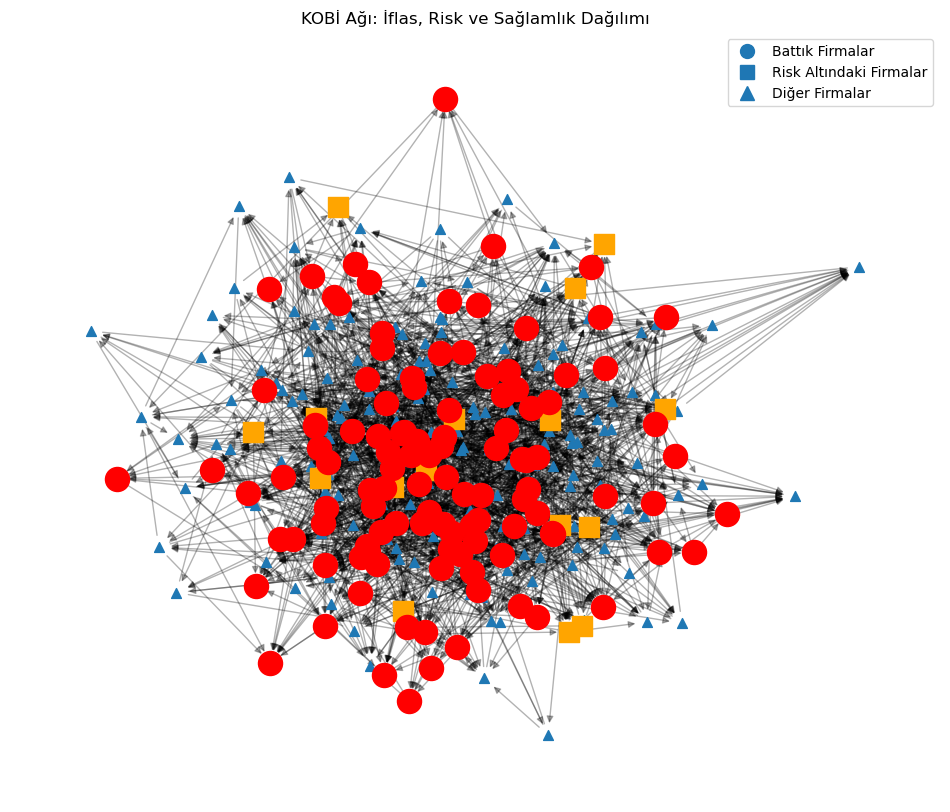

In [ ]:
from matplotlib.lines import Line2D
risk_threshold = full_df['hibrit_iflas_skoru'].quantile(0.8)
risk_dict = dict(zip(full_df['firma_id'], full_df['hibrit_iflas_skoru']))

failed_nodes = list(batik_firmalar)
risk_nodes = [n for n in G.nodes() if n not in batik_firmalar and risk_dict.get(n, 0) >= risk_threshold]
other_nodes = [n for n in G.nodes() if n not in batik_firmalar and risk_dict.get(n, 0) < risk_threshold]

pos = nx.spring_layout(G, k=0.5, seed=42)
plt.figure(figsize=(12, 10))
nx.draw_networkx_edges(G, pos, alpha=0.3)
nx.draw_networkx_nodes(G, pos, nodelist=other_nodes, node_shape='^', node_size=50)
nx.draw_networkx_nodes(G, pos, nodelist=risk_nodes, node_shape='s', node_size=200, node_color='orange')
nx.draw_networkx_nodes(G, pos, nodelist=failed_nodes, node_shape='o', node_size=300, node_color='red')

legend_handles = [
    Line2D([], [], marker='o', linestyle='None', markersize=10, label='Battık Firmalar'),
    Line2D([], [], marker='s', linestyle='None', markersize=10, label='Risk Altındaki Firmalar'),
    Line2D([], [], marker='^', linestyle='None', markersize=10, label='Diğer Firmalar')
]
plt.legend(handles=legend_handles)
plt.title("KOBİ Ağı: İflas, Risk ve Sağlamlık Dağılımı")
plt.axis('off')
plt.show()
